In [1]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
sys.path.append('../input/pytorch-optimizers/')

In [2]:
import os
import gc
import cv2
import copy
import time
import yaml
import random
import shutil
import warnings
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from PIL import Image, ImageDraw
from shutil import copyfile
from IPython.core.display import Video, display
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GroupKFold, StratifiedKFold

import timm
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn.modules.loss import _WeightedLoss
from torchvision import models, transforms
from torch_optimizer.radam import RAdam

from albumentations.pytorch import ToTensorV2
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout,
    ShiftScaleRotate, CenterCrop, Resize, Rotate, RandomRotate90, RGBShift, ChannelShuffle)

warnings.simplefilter('ignore')
pd.set_option("max_columns", 150)
pd.set_option('display.max_rows', 150)

In [3]:
#timm.list_models(pretrained=True)

# Configuration

In [4]:
CFG = {
    "save_prev"   : [True, ["petfinder_*_p2_0.pt", "petfinder_*_p2_1.pt", "petfinder_*_p2_2.pt", "petfinder_*_p2_3.pt", "petfinder_*type2*.pt"]],
    "seed"        : 42,
    'device'      : "cuda:0" if torch.cuda.is_available() else "cpu",
    "input_img"   : '../input/petfinder-pawpularity-score/train/',
    "input_path"  : '../input/petfinder-smogn-dataset/train_drop_duplicated.csv',
    "output_path" : './',
    "db_model"    : 'swin_large_patch4_window7_224_in22k',
    "db_size"     : 224,
    "pretrain"    : "../input/petfinder-semisupervised-models/petfinder_swin_binary_ss_type2_7.pt",
    "save_name"   : "petfinder_swin_binary_p2_ss_type2_bins",
    "model"       : "swin_large_patch4_window7_224_in22k",
    "loss"        : "binary",
    "size"        : 224,
    "fold"        : 4,
    "break_fold"  : 99,
    "batch_size"  : 32,
    "epochs"      : 3,
    "mixup_ratio" : 0.2,
    'T_0'         : 20,
    "lr"          : 2e-5,
    'momentum'    : 0.9,
    'weight_decay': 1e-4,
    "accum_iter"  : 2,
    "run_valid_in_training" : 99,  # Epoch starts 0.
    "step_valid_in_training": 32,  # Run valid every 32 steps.
    'early_stopping': 10,
    'verbose_step'  : 1,
    "num_workers"   : 4
}

CFG

{'save_prev': [True,
  ['petfinder_*_p2_0.pt',
   'petfinder_*_p2_1.pt',
   'petfinder_*_p2_2.pt',
   'petfinder_*_p2_3.pt',
   'petfinder_*type2*.pt']],
 'seed': 42,
 'device': 'cuda:0',
 'input_img': '../input/petfinder-pawpularity-score/train/',
 'input_path': '../input/petfinder-smogn-dataset/train_drop_duplicated.csv',
 'output_path': './',
 'db_model': 'swin_large_patch4_window7_224_in22k',
 'db_size': 224,
 'pretrain': '../input/petfinder-semisupervised-models/petfinder_swin_binary_ss_type2_7.pt',
 'save_name': 'petfinder_swin_binary_p2_ss_type2_bins',
 'model': 'swin_large_patch4_window7_224_in22k',
 'loss': 'binary',
 'size': 224,
 'fold': 4,
 'break_fold': 99,
 'batch_size': 32,
 'epochs': 3,
 'mixup_ratio': 0.2,
 'T_0': 20,
 'lr': 2e-05,
 'momentum': 0.9,
 'weight_decay': 0.0001,
 'accum_iter': 2,
 'run_valid_in_training': 99,
 'step_valid_in_training': 32,
 'early_stopping': 10,
 'verbose_step': 1,
 'num_workers': 4}

In [5]:
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

def sigmoid(a):
    return 1 / (1 + np.exp(-a))

def softmax(x):
    max = np.max(x,axis=1,keepdims=True)
    e_x = np.exp(x - max)
    sum = np.sum(e_x,axis=1,keepdims=True)
    return e_x / sum 

def seed_everything(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG["seed"])

In [6]:
if CFG['save_prev'][0]:
    for file_pattern in CFG['save_prev'][1]:
        for f in glob(f"../input/petfinder-models-pseudolabel-2/{file_pattern}"):
            filename = os.path.basename(f)
            !cp {f} ./{filename}

# Load data

In [7]:
df_train = pd.read_csv(CFG['input_path'])
df_train["path"] = [f"{CFG['input_img']}{i}.jpg" for i in df_train.Id]
df_train["Pawclass"] = df_train.Pawpularity / 100

num_bins = int(np.ceil(2*((len(df_train))**(1./3))))
df_train['bins'] = pd.cut(df_train['Pawclass'], bins=num_bins, labels=False)

meta_features = [c for c in df_train.columns if c not in ["Id","path", "Pawpularity","Pawclass","bins"]]

print(meta_features)
print(df_train.shape)
df_train.head(2)

['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']
(9860, 17)


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,Pawclass,bins
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,../input/petfinder-pawpularity-score/train/000...,0.63,26
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,../input/petfinder-pawpularity-score/train/000...,0.42,17


In [8]:
df_train.describe()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,Pawclass,bins
count,9860.000000,9860.000000,9860.000000,9860.000000,9860.000000,9860.000000,9860.000000,9860.000000,9860.000000,9860.000000,9860.000000,9860.000000,9860.000000,9860.000000,9860.000000
mean,0.027586,0.772008,0.903651,0.861460,0.009838,0.067647,0.129209,0.048479,0.165619,0.171197,0.060446,0.070791,38.066227,0.380662,15.577383
std,0.163792,0.419559,0.295084,0.345483,0.098701,0.251152,0.335448,0.214786,0.371757,0.376700,0.238324,0.256489,20.612391,0.206124,8.920380
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.010000,0.000000
25%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,0.250000,10.000000
50%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000,0.330000,13.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000,0.460000,19.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000,1.000000,42.000000


<AxesSubplot:>

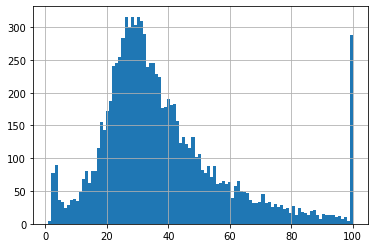

In [9]:
df_train.Pawpularity.hist(bins=100)

# Define model

In [10]:
class Model(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=3)
        self.n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(self.n_features, 1)

    def forward(self, x):
        output = self.model(x)
        return output

class SwinModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model   = timm.create_model(model_name, pretrained=pretrained, num_classes=0, in_chans=3)
        num_features = self.model.num_features
        self.linear  = nn.Linear(num_features, 1)

    def forward(self, x):
        x = self.model(x)
        output = self.linear(x)
        return output

In [11]:
class PetFinderDataset(Dataset):
    def __init__(self, df_img, df_meta, transforms=None, train=True, output_meta=True, output_label=True):
        super().__init__()
        self.df_img  = df_img.reset_index(drop=True).copy()
        self.df_meta = df_meta.reset_index(drop=True).copy()
        self.transforms   = transforms
        self.train        = train
        self.output_meta  = output_meta
        self.output_label = output_label
        
    def __len__(self):
        return self.df_img.shape[0]
    
    def __getitem__(self, index: int):
        img = get_img(self.df_img.loc[index].path)
        y   = torch.from_numpy(np.array(self.df_img.loc[index].Pawclass))  # Pawpularity
        if self.output_meta:
            meta = torch.from_numpy(np.array(self.df_meta.loc[index], dtype=float))
        if self.transforms:
            if self.train:
                img = self.transforms(image=img)['image']
            else:
                h, w, _ = img.shape
                trans = self.transforms(h, w)
                img   = trans(image=img)['image']
        if self.output_label:
            if self.output_meta:
                return img, meta, y
            else:
                return img, y
        if self.output_meta:
            return img, meta
        return img

In [12]:
def get_train_transforms():
    return Compose([
        Resize(CFG['size'], CFG['size'], p=1.0),
        HorizontalFlip(p=0.5),
        HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)], p=1.0)
  
def get_valid_transforms(h, w):
    return Compose([
        Resize(CFG['size'], CFG['size'], p=1.0),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)], p=1.0)

#https://www.kaggle.com/heyytanay/definitive-pytorch-trainer-mixup-kfolds-w-b
def mixup_augmentation(x:torch.Tensor, y:torch.Tensor, alpha:float = 1.0):
    """
    Function which performs Mixup augmentation
    """
    assert alpha > 0, "Alpha must be greater than 0"
    assert x.shape[0] > 1, "Need more than 1 sample to apply mixup"

    lam = np.random.beta(alpha, alpha)
    rand_idx = torch.randperm(x.shape[0])
    mixed_x  = lam * x + (1 - lam) * x[rand_idx, :]
    target_a, target_b = y, y[rand_idx]
    return mixed_x, target_a, target_b, lam

def prepare_dataloader(train, valid, train_meta=None, valid_meta=None):
    if train_meta is None or valid_meta is None:
        train_ds = PetFinderDataset(train, pd.DataFrame(), transforms=get_train_transforms(), output_meta=False)
        valid_ds = PetFinderDataset(valid, pd.DataFrame(), transforms=get_valid_transforms, train=False, output_meta=False)
    else:
        train_ds = PetFinderDataset(train, train_meta, transforms=get_train_transforms())
        valid_ds = PetFinderDataset(valid, valid_meta, transforms=get_valid_transforms, train=False)
    train_loader = torch.utils.data.DataLoader(train_ds,
                                               batch_size=CFG['batch_size'],
                                               drop_last=False,
                                               pin_memory=False,
                                               shuffle=True,
                                               num_workers=CFG['num_workers'])
    val_loader = torch.utils.data.DataLoader(valid_ds,
                                             batch_size=CFG['batch_size'],
                                             pin_memory=False,
                                             shuffle=False,
                                             num_workers=CFG['num_workers'])
    return train_loader, val_loader

In [13]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, val_loader, device,
                    scheduler=None, schd_batch_update=False, best_rmse=999):
    t = time.time()
    running_loss = None
    mean_loss    = 0
    best_model   = None
    best_hist    = None

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, targets) in pbar:
        model.train()

        imgs    = imgs.to(device).float()
        targets = targets.reshape(-1,1).to(device).float()

        if torch.rand(1)[0] < CFG["mixup_ratio"]:
            mix_img, tar_a, tar_b, lam = mixup_augmentation(imgs, targets, alpha=0.5)
            with autocast():
                img_preds = model(mix_img)
                # Mixup loss calculation
                loss_a = loss_fn(img_preds, tar_a)
                loss_b = loss_fn(img_preds, tar_b)
                loss = (loss_a * lam + (1 - lam) * loss_b) / CFG['accum_iter']
        else:
            with autocast():
                img_preds = model(imgs)
                loss = loss_fn(img_preds, targets) / CFG['accum_iter']
        scaler.scale(loss).backward()

        if running_loss is None:
            running_loss = loss.item()
        else:
            running_loss = running_loss * .99 + loss.item() * .01
        mean_loss += loss.item()

        if ((step + 1) %  CFG['accum_iter'] == 0) or ((step + 1) == len(train_loader)):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad() 
            if scheduler is not None and schd_batch_update:
                scheduler.step()

        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
            description = f'epoch {epoch} loss: {running_loss:.4f}'
            pbar.set_description(description)
                
        if CFG["run_valid_in_training"] <= epoch and (step + 1) % CFG["step_valid_in_training"] == 0:
            with torch.no_grad():
                valid_rmse, _, valid_hist = valid_one_epoch(epoch, model, loss_fn, val_loader, device)
            if valid_rmse < best_rmse:
                best_model = copy.deepcopy(model)
                best_rmse  = valid_rmse
                best_hist  = valid_hist
                
    if scheduler is not None and not schd_batch_update:
        scheduler.step()
        
    return mean_loss/len(train_loader), best_rmse, best_model, best_hist
        
def valid_one_epoch(epoch, model, loss_fn, val_loader, device,
                    scheduler=None, schd_loss_update=False):
    model.eval()

    t = time.time()
    loss_sum   = 0
    sample_num = 0
    img_preds_all = []
    img_truth_all = []
    
    for step, (imgs, targets) in enumerate(val_loader):
        imgs    = imgs.to(device)
        targets = targets.reshape(-1,1).to(device).float()
        
        img_preds = model(imgs)
        img_preds_all += [img_preds.detach().cpu().numpy()]
        img_truth_all += [targets.detach().cpu().numpy()]
        
        loss = loss_fn(img_preds, targets)
        loss_sum   += loss.item()*targets.shape[0]
        sample_num += targets.shape[0]  

    if CFG["loss"] == "binary":
        img_preds_all = (sigmoid(np.concatenate(img_preds_all))*100).astype(int)
        img_truth_all = (np.concatenate(img_truth_all)*100).astype(int)
    else:
        img_preds_all = np.concatenate(img_preds_all)
        img_truth_all = np.concatenate(img_truth_all)
    rmse = np.sqrt(mean_squared_error(img_preds_all, img_truth_all))
    print('validation rmse = {:.6f}'.format(rmse))
    
    if scheduler is not None:
        if schd_loss_update:
            scheduler.step(loss_sum/sample_num)
        else:
            scheduler.step()
            
    return loss_sum/sample_num, rmse,  [img_preds_all, img_truth_all]

In [14]:
def sgd_optimizer(model, lr, momentum, weight_decay):
    params = []
    for key, value in model.named_parameters():
        if not value.requires_grad:
            continue
        apply_weight_decay = weight_decay
        apply_lr = lr
        if 'bias' in key or 'bn' in key:
            apply_weight_decay = 0
        if 'bias' in key:
            apply_lr = 2 * lr       # Just a Caffe-style common practice. Made no difference.
        params += [{'params': [value], 'lr': apply_lr, 'weight_decay': apply_weight_decay}]
    optimizer = torch.optim.SGD(params, lr, momentum=momentum)
    return optimizer

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))

# Run training

In [15]:
folds = StratifiedKFold(
    n_splits=CFG['fold'],
    shuffle=True,
    random_state=CFG['seed']
).split(np.arange(df_train.shape[0]), df_train.bins.values)
    
all_histories = {}
for fold, (trn_idx, val_idx) in enumerate(folds):
    print('Training with fold {} started'.format(fold))
    print(len(trn_idx), len(val_idx))
    
    train      = df_train.iloc[trn_idx].reset_index(drop=True)
    valid      = df_train.iloc[val_idx].reset_index(drop=True)
    train_loader, val_loader = prepare_dataloader(train, valid)

    not_improved_cnt = 0
    best_rmse  = 999
    best_epoch = 0
    histories  = {}
    device     = torch.device(CFG['device'])
    
    if -1 < CFG["model"].find("swin"):
        model = SwinModel(CFG["model"], pretrained=True)
    else:
        model = Model(CFG["model"], pretrained=True)
    if CFG['pretrain'] is not None:
        pretrained_weights = CFG['pretrain'] % fold if -1 < CFG['pretrain'].find("%") else CFG['pretrain']
        model.load_state_dict(torch.load(pretrained_weights))
    model.to(device)
    scaler    = GradScaler()
    #optimizer = sgd_optimizer(model, CFG['lr'], CFG['momentum'], CFG['weight_decay'])
    #scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=CFG['T_0'])
    optimizer = RAdam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
    scheduler = None
    if CFG["loss"] == "binary":
        loss_fn = nn.BCEWithLogitsLoss().to(device)
    else:
        loss_fn = RMSELoss().to(device)

    for epoch in range(CFG['epochs']):
        train_loss, train_best_rmse, train_best_model, train_best_hist = train_one_epoch(
            epoch,
            model,
            loss_fn,
            optimizer,
            train_loader,
            val_loader,
            device,
            scheduler=scheduler,
            best_rmse=best_rmse
        )
        with torch.no_grad():
            valid_loss, valid_rmse, valid_hist = valid_one_epoch(
                epoch,
                model,
                loss_fn,
                val_loader,
                device
            )
        if valid_rmse < train_best_rmse:
            histories[epoch] = [train_loss, valid_loss, valid_rmse, valid_hist]
        else:
            histories[epoch] = [train_loss, valid_loss, train_best_rmse, train_best_hist]

        if valid_rmse < best_rmse or train_best_rmse < best_rmse:
            print('Best model will be saved to output path after completing this fold')
            if valid_rmse < train_best_rmse:
                best_model = copy.deepcopy(model)
                best_rmse  = valid_rmse
            else:
                best_model = copy.deepcopy(train_best_model)
                best_rmse  = train_best_rmse
            best_epoch = epoch
            not_improved_cnt = 0
        elif CFG['early_stopping'] == not_improved_cnt:
            print("Met early stopping.")
            break
        else:
            not_improved_cnt += 1

    torch.save(best_model.state_dict(), f"{CFG['output_path']}{CFG['save_name']}_{fold}.pt")
    all_histories[fold] = [best_epoch, histories]
    
    del model, optimizer, train_loader, val_loader, scaler
    torch.cuda.empty_cache()
    
    if CFG["break_fold"] == fold+1:
        break

Training with fold 0 started
7395 2465


Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_large_patch4_window7_224_22k.pth" to /root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22k.pth
epoch 0 loss: 0.3197: 100%|██████████| 232/232 [05:27<00:00,  1.41s/it]


validation rmse = 17.267646
Best model will be saved to output path after completing this fold


epoch 1 loss: 0.3200: 100%|██████████| 232/232 [05:21<00:00,  1.39s/it]


validation rmse = 17.174572
Best model will be saved to output path after completing this fold


epoch 2 loss: 0.3185: 100%|██████████| 232/232 [05:22<00:00,  1.39s/it]


validation rmse = 17.124683
Best model will be saved to output path after completing this fold
Training with fold 1 started
7395 2465


epoch 0 loss: 0.3177: 100%|██████████| 232/232 [05:22<00:00,  1.39s/it]


validation rmse = 17.529506
Best model will be saved to output path after completing this fold


epoch 1 loss: 0.3163: 100%|██████████| 232/232 [05:23<00:00,  1.39s/it]


validation rmse = 17.595811


epoch 2 loss: 0.3170: 100%|██████████| 232/232 [05:22<00:00,  1.39s/it]


validation rmse = 17.538517
Training with fold 2 started
7395 2465


epoch 0 loss: 0.3222: 100%|██████████| 232/232 [05:23<00:00,  1.39s/it]


validation rmse = 16.811278
Best model will be saved to output path after completing this fold


epoch 1 loss: 0.3184: 100%|██████████| 232/232 [05:23<00:00,  1.40s/it]


validation rmse = 16.689760
Best model will be saved to output path after completing this fold


epoch 2 loss: 0.3190: 100%|██████████| 232/232 [05:24<00:00,  1.40s/it]


validation rmse = 16.676580
Best model will be saved to output path after completing this fold
Training with fold 3 started
7395 2465


epoch 0 loss: 0.3198: 100%|██████████| 232/232 [05:23<00:00,  1.39s/it]


validation rmse = 17.310527
Best model will be saved to output path after completing this fold


epoch 1 loss: 0.3178: 100%|██████████| 232/232 [05:24<00:00,  1.40s/it]


validation rmse = 17.329430


epoch 2 loss: 0.3172: 100%|██████████| 232/232 [05:23<00:00,  1.40s/it]


validation rmse = 17.354156


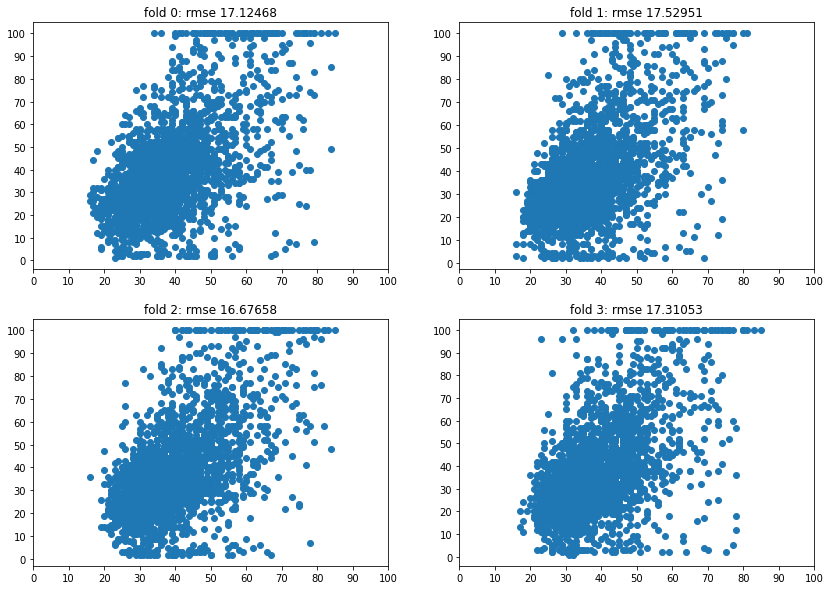

In [16]:
c, r, cnt = 2, 2, 0
fig, axes = plt.subplots(nrows=r, ncols=c, figsize=(14, 10))
for i in range(r):
    for j in range(c):
        if cnt not in all_histories.keys():
            continue
        best_epoch, histories = all_histories[cnt]
        rmse, (pred, gt) = histories[best_epoch][2:]
        axes[i, j].scatter(x=pred, y=gt)
        axes[i, j].set_xticks(np.arange(0,101,10))
        axes[i, j].set_yticks(np.arange(0,101,10))
        axes[i, j].set_title(f"fold {cnt}: rmse {round(rmse,5)}")
        cnt += 1
fig.show()